In [28]:
#%matplotlib notebook
%matplotlib inline
from matplotlib import rc
rc('figure',figsize=(12,10))
rc('font',size=12)
rc('text',usetex=False)

from qubicpack import qubicpack as qp
import fibtools as ft
import plotters as p
import lin_lib as ll

import numpy as np
from matplotlib.pyplot import *
import matplotlib.mlab as mlab
import scipy.ndimage.filters as f
import glob
import string
import datetime as dt

There are two datasets to be anayzed:
- *linearityA* : offset is always 1V and we go from 0.5V to 2V amplitude. In this dataset the modulation does not always reach zero amplitude for the source.
- *linearityB* : Amplitude is always 2xOffset so that the modulation always goes from 0 to Amplitude 

In the following cell we read the corresponding filenames and order them, detect the offstes, amplitudes and modulation frequencies. We order the files by the amplitude of the modulation.

In [3]:
day = '2019-03-01'
data_dir = '/qubic/Data/Calib-TD/'+day+'/'
dirs = np.array(glob.glob(data_dir+'/*LinearityA*'))
dirs.sort()

#if day=='2019-02-28':
#    dirs = dirs[0:-1]

print dirs
print ''
labels = []
for d in dirs:
    bla = str.split(d,'__')
    labels.append(bla[1])
labels = np.array(labels)

modfreqs = np.zeros(len(labels))
amps = np.zeros(len(labels))
offsets = np.zeros(len(labels))
for i in xrange(len(labels)):
    bla = str.split(labels[i],'_')
    modfreqs[i] = np.float(bla[2][0:len(bla[2])-2])
    amps[i] = np.float(bla[4])
    offsets[i] = np.float(bla[6])

    
order = np.argsort(amps)
modfreqs = modfreqs[order]
amps = amps[order]
offsets = offsets[order]
labels = labels[order]
dirs = dirs[order]
print ''
print(dirs)
print ''
print labels
print(amps)
print(offsets)
print(modfreqs)

['/qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.35.25__LinearityA_sin_0.333Hz_amp_1.250_off_2.500'
 '/qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.38.21__LinearityA_sin_0.333Hz_amp_1.500_off_2.500'
 '/qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.41.24__LinearityA_sin_0.333Hz_amp_1.750_off_2.500'
 '/qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.44.29__LinearityA_sin_0.333Hz_amp_2.000_off_2.500'
 '/qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.47.47__LinearityA_sin_0.333Hz_amp_2.500_off_2.500'
 '/qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.50.46__LinearityA_sin_0.333Hz_amp_3.000_off_2.500'
 '/qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.53.34__LinearityA_sin_0.333Hz_amp_3.500_off_2.500'
 '/qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.56.25__LinearityA_sin_0.333Hz_amp_4.000_off_2.500'
 '/qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.59.19__LinearityA_sin_0.333Hz_amp_4.500_off_2.500'
 '/qubic/Data/Calib-TD/2019-03-01/2019-03-01_15.02.19__LinearityA_sin_0.333Hz_amp_5.000_off_2.500']


['/qubi

And there are source data associated, that are read below. It contains time (computer-time from the rasberry pi) and amplitude of the power-meter. We read them all for this day and concatenate them. Later we'll pick the common period corresponding to each data file.

['/qubic/Data/Calib-TD/calsource/calsource_20190301T133531.dat', '/qubic/Data/Calib-TD/calsource/calsource_20190301T133828.dat', '/qubic/Data/Calib-TD/calsource/calsource_20190301T134131.dat', '/qubic/Data/Calib-TD/calsource/calsource_20190301T134435.dat', '/qubic/Data/Calib-TD/calsource/calsource_20190301T134754.dat', '/qubic/Data/Calib-TD/calsource/calsource_20190301T135053.dat', '/qubic/Data/Calib-TD/calsource/calsource_20190301T135340.dat', '/qubic/Data/Calib-TD/calsource/calsource_20190301T135631.dat', '/qubic/Data/Calib-TD/calsource/calsource_20190301T135925.dat', '/qubic/Data/Calib-TD/calsource/calsource_20190301T140226.dat']


(0, 256)

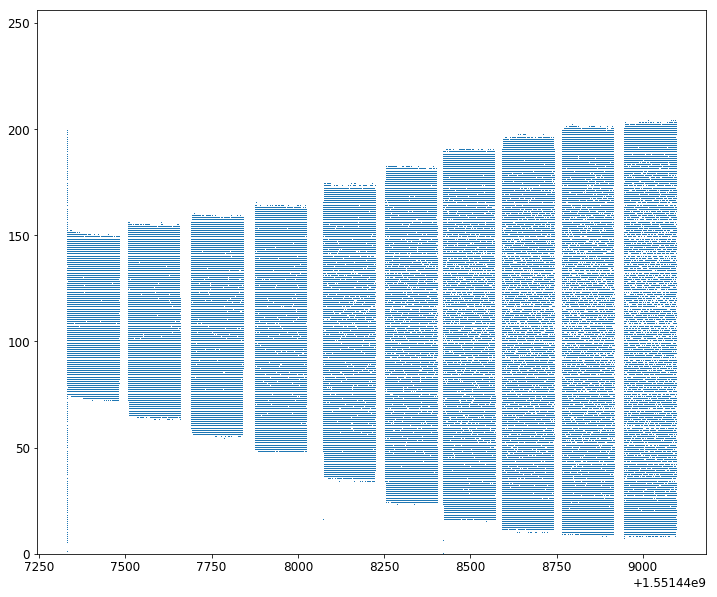

In [5]:
### The date format for calsrc has no '-' so we need to change the day to this very format.
daycalsrc = "".join(str.split(day,'-'))
fcalsrc = glob.glob('/qubic/Data/Calib-TD/calsource/*'+daycalsrc+'*')
fcalsrc.sort()
print fcalsrc

ttsrc = []
ddsrc = []
for ff in fcalsrc:
    thett, thedd = np.loadtxt(ff).T
    ttsrc.append(thett+3600)
    ddsrc.append(thedd)
    
ttsrc = np.concatenate(ttsrc)
ddsrc = np.concatenate(ddsrc)
plot(ttsrc,ddsrc,',')
ylim(0,256)

Now we read the data for both asics and for each TES, we only keep the data for which the source data is common with the TES data.

In [7]:
tt = []
dd = []
tt_src = []
dd_src = []
for thedir in dirs:
    print 'Directory :'
    print '-----------'
    print(thedir)
    dd_asic = []
    tt_asic = []
    dd_src_asic = []
    tt_src_asic = []    
    for asicnum in [1,2]:
        print 'ASIC Number: {}'.format(asicnum) 
        print '------------' 
        a = qp()
        a.read_qubicstudio_dataset(thedir, asic=asicnum)
        FREQ_SAMPLING = 1./a.sample_period()
        
        ######## Getting the time axis #############################
        #### Old version: no PPS, data timeline is just a linspace
        t_data = a.timeline_timeaxis(axistype='index')
        t0 = a.timeline_timeaxis(axistype='pps')[0]
        t_data = t_data + t0
        #### NEW version with PPS accounted for
        #t_data = a.timeline_timeaxis(axistype='pps')
        #t0 = t_data[0]
        #############################################################

        #################### Getting regions of common data between source and data ###############
        ### Find the region where there is source data
        oksrc = (ttsrc >= (t_data[0])) & (ttsrc <=(t_data[-1]))
        print 'Number of common points: {}'.format(oksrc.sum())
        thettsrc = ttsrc[oksrc]
        theddsrc = ddsrc[oksrc]
        ### now reduce each to matching regions
        mini = np.max([np.min(t_data), np.min(thettsrc)])
        maxi = np.min([np.max(t_data), np.max(thettsrc)])
        okdata = (t_data >= mini) & (t_data <= maxi)
        oksrc = (thettsrc >= mini) & (thettsrc <= maxi)
        t_data = t_data[okdata]
        thettsrc = thettsrc[oksrc]
        theddsrc = theddsrc[oksrc]
        # APpend these to the asic data
        tt_asic.append(t_data-t0)
        tt_src_asic.append(thettsrc-t0)
        dd_src_asic.append(theddsrc)
        ############################################################################################
        
        nsamples = len(t_data)
        alldata = np.zeros((128, nsamples))
        for TESindex in xrange(128):
            TESnum = TESindex + 1
            ######## Getting the data and reduce it to relevant region (w.r.t. source data)
            data = a.timeline(TES=TESnum)
            alldata[TESindex,:] = data[okdata]
            
        # Append this data to the ddasic variable    
        dd_asic.append(alldata)

    tt.append(tt_asic)
    dd.append(dd_asic)
    tt_src.append(tt_src_asic)
    dd_src.append(dd_src_asic)

Directory :
-----------
/qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.35.25__LinearityA_sin_0.333Hz_amp_1.250_off_2.500
ASIC Number: 1
------------
Reading data for ASIC 1
reading fits file: /qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.35.25__LinearityA_sin_0.333Hz_amp_1.250_off_2.500/Sums/science-asic1-2019.03.01.143525.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.35.25__LinearityA_sin_0.333Hz_amp_1.250_off_2.500/Sums/science-asic1-2019.03.01.143525.fits
Guessing the detector array is: P87
No MMR data found in directory: /qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.35.25__LinearityA_sin_0.333Hz_amp_1.250_off_2.500/Hks
reading fits file: /qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.35.25__LinearityA_sin_0.333Hz_amp_1.250_off_2.500/Hks/hk-intern-2019.03.01.143529.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.35.25__LinearityA_sin_0.333Hz_amp_1.250_off_2.500/Hks/hk-intern-2019.03.01.143529.fits
reading fits file:

Guessing the detector array is: P87
No MMR data found in directory: /qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.41.24__LinearityA_sin_0.333Hz_amp_1.750_off_2.500/Hks
reading fits file: /qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.41.24__LinearityA_sin_0.333Hz_amp_1.750_off_2.500/Hks/hk-intern-2019.03.01.144124.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.41.24__LinearityA_sin_0.333Hz_amp_1.750_off_2.500/Hks/hk-intern-2019.03.01.144124.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.41.24__LinearityA_sin_0.333Hz_amp_1.750_off_2.500/Hks/conf-asics-2019.03.01.144126.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.41.24__LinearityA_sin_0.333Hz_amp_1.750_off_2.500/Hks/conf-asics-2019.03.01.144126.fits
There are 31 housekeeping measurements in the period 2019-03-01 14:41:28 to 2019-03-01 14:43:59
WARNING!  Assuming Raw-mask did not change during the measurement.
          You can check by looking 

setting pps interval to 1 second
Number of common points: 31876
ASIC Number: 2
------------
Reading data for ASIC 2
reading fits file: /qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.47.47__LinearityA_sin_0.333Hz_amp_2.500_off_2.500/Sums/science-asic2-2019.03.01.144748.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.47.47__LinearityA_sin_0.333Hz_amp_2.500_off_2.500/Sums/science-asic2-2019.03.01.144748.fits
Guessing the detector array is: P87
No MMR data found in directory: /qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.47.47__LinearityA_sin_0.333Hz_amp_2.500_off_2.500/Hks
reading fits file: /qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.47.47__LinearityA_sin_0.333Hz_amp_2.500_off_2.500/Hks/hk-intern-2019.03.01.144748.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.47.47__LinearityA_sin_0.333Hz_amp_2.500_off_2.500/Hks/hk-intern-2019.03.01.144748.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.47.47__Li

Guessing the detector array is: P87
No MMR data found in directory: /qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.53.34__LinearityA_sin_0.333Hz_amp_3.500_off_2.500/Hks
reading fits file: /qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.53.34__LinearityA_sin_0.333Hz_amp_3.500_off_2.500/Hks/hk-intern-2019.03.01.145334.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.53.34__LinearityA_sin_0.333Hz_amp_3.500_off_2.500/Hks/hk-intern-2019.03.01.145334.fits
reading fits file: /qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.53.34__LinearityA_sin_0.333Hz_amp_3.500_off_2.500/Hks/conf-asics-2019.03.01.145334.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.53.34__LinearityA_sin_0.333Hz_amp_3.500_off_2.500/Hks/conf-asics-2019.03.01.145334.fits
There are 31 housekeeping measurements in the period 2019-03-01 14:53:37 to 2019-03-01 14:56:08
WARNING!  Assuming Raw-mask did not change during the measurement.
          You can check by looking 

mean separation between pulses is 1.00 second
setting pps interval to 1 second
Number of common points: 32041
Directory :
-----------
/qubic/Data/Calib-TD/2019-03-01/2019-03-01_15.02.19__LinearityA_sin_0.333Hz_amp_5.000_off_2.500
ASIC Number: 1
------------
Reading data for ASIC 1
reading fits file: /qubic/Data/Calib-TD/2019-03-01/2019-03-01_15.02.19__LinearityA_sin_0.333Hz_amp_5.000_off_2.500/Sums/science-asic1-2019.03.01.150219.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-01/2019-03-01_15.02.19__LinearityA_sin_0.333Hz_amp_5.000_off_2.500/Sums/science-asic1-2019.03.01.150219.fits
Guessing the detector array is: P87
No MMR data found in directory: /qubic/Data/Calib-TD/2019-03-01/2019-03-01_15.02.19__LinearityA_sin_0.333Hz_amp_5.000_off_2.500/Hks
reading fits file: /qubic/Data/Calib-TD/2019-03-01/2019-03-01_15.02.19__LinearityA_sin_0.333Hz_amp_5.000_off_2.500/Hks/hk-intern-2019.03.01.150219.fits
Reading QubicStudio FITS file: /qubic/Data/Calib-TD/2019-03-01/2019-03-0

We now fold the data into a period of the modulation frequency with a given binning. The data is then fit with three different curves:
* A sine wave for which we fix the frequency to that of the source
* The source data itself coming from the power meter, shifted in phase, amplitude and offset [NB we should not have to fit the phase but for now there probably remains a synchronization issue that is solved by this phase-shift)
* The model of the source signal accounting for the source instrinsic non-linearity at a given modulation amplitude and offset.

In [15]:
print len(dd)
print(tt[0])
print(len(tt[0]))
print(len(tt[0][0]))

10
[array([6.40010834e-03, 1.27999783e-02, 1.92000866e-02, ...,
       1.48358400e+02, 1.48364800e+02, 1.48371200e+02]), array([6.40010834e-03, 1.27999783e-02, 1.92000866e-02, ...,
       1.48358400e+02, 1.48364800e+02, 1.48371200e+02])]
2
23183


In [63]:
reload(ll)

nbins = 50
allfolded = np.zeros((len(dirs), 2, 128, nbins))
allfolded_error = np.zeros((len(dirs), 2, 128, nbins))
allfolded_src = np.zeros((len(dirs), 2, 128, nbins))
allresfit = np.zeros((len(dirs), 2, 128, 4))
allerrfit = np.zeros((len(dirs), 2, 128, 4))
allresfit_src = np.zeros((len(dirs), 2, 128, 3))
allerrfit_src = np.zeros((len(dirs), 2, 128, 3))
allresfit_src_model = np.zeros((len(dirs), 2, 128, 6))
allerrfit_src_model = np.zeros((len(dirs), 2, 128, 6))

for ii in xrange(len(dirs)):
    print('Directory {}/{} : {}'.format(ii+1, len(dirs), dirs[ii]))
    modulation_frequency = modfreqs[ii]
    for asicindex in xrange(2):
        print('   Asic {}'.format(asicindex+1))
        ##### Folding Data
        print('        - Folding data')
        time = tt[ii][asicindex]
        ns = len(time)
        tesdata = -dd[ii][asicindex]   # Minus sign in order to have positive power in positive direction
        folded, t, folded_nonorm, dy = ft.fold_data(time, tesdata, 
                                            1./modulation_frequency, 0.01, 100., nbins, 
                                                    notch=None, return_error=True, silent=True)
        allfolded[ii, asicindex, :, :] = folded_nonorm
        allfolded_error[ii, asicindex, :, :] = dy

        ##### Folding Source data
        print('        - Folding Source')
        srctime = tt_src[ii][asicindex]
        srcdata = np.reshape(dd_src[ii][asicindex], (1,len(dd_src[ii][asicindex])))
        folded_src, tsrc, folded_nonorm_src, dy_src = ft.fold_data(srctime, srcdata, 
                                            1./modulation_frequency, 0.01, 100., nbins, 
                                            notch=None, return_error=True, silent=True)
        allfolded_src[ii,asicindex, :, :] = folded_nonorm_src
        
        ##### Now fitting each TES with the curves
        print('        - Fitting Sine for all TES')
        for TESindex in xrange(128):
            ##### Fitting folded data with a sine
            guess = np.array([5000.*amps[ii], 1./modulation_frequency, 1.,0.])
            res = ft.do_minuit(t,allfolded[ii, asicindex, TESindex, :], allfolded_error[ii, asicindex, TESindex, :], 
                               guess, functname=ll.sine, fixpars=[0,1,0,0],verbose=False, force_chi2_ndf=True)
            allresfit[ii, asicindex, TESindex, :] = res[1]
            allerrfit[ii, asicindex, TESindex, :] = res[2]

        print('        - Fitting CalSrc data for all TES')
        for TESindex in xrange(128):
            ##### Fitting a possible shift in t and y to source data
            guess = np.array([600, 0.1,100])
            xyper = [tsrc,allfolded_src[ii, asicindex, TESindex, :], 1./modulation_frequency]
            res = ft.do_minuit(xyper,allfolded[ii, asicindex, TESindex, :], allfolded_error[ii, asicindex, TESindex, :], 
                                guess, functname=ll.shift_src, fixpars=[0,0,0],verbose=False, force_chi2_ndf=True, nohesse=True)
            allresfit_src[ii, asicindex, TESindex,:] = res[1]
            allerrfit_src[ii, asicindex, TESindex,:] = res[2]    
    
        print('        - Fitting CalSrc Model for all TES')
        for TESindex in xrange(128):
            ##### Fitting The model source data
            guess = np.array([600, np.mean(allfolded[ii, asicindex, TESindex:]),  
                              amps[ii], 1./modfreqs[ii],np.mean(t), offsets[ii]])
            res = ft.do_minuit(t,allfolded[ii, asicindex, TESindex, :], allfolded_error[ii, asicindex, TESindex, :], 
                                guess, functname=ll.sinesat, fixpars=[0,0,1,1,0,1],verbose=False, force_chi2_ndf=True, nohesse=True)
            allresfit_src_model[ii, asicindex, TESindex,:] = res[1]
            allerrfit_src_model[ii, asicindex, TESindex,:] = res[2]

Directory 1/10 : /qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.35.25__LinearityA_sin_0.333Hz_amp_1.250_off_2.500
   Asic 1
        - Folding data
        - Folding Source
        - Fitting Sine for all TES
        - Fitting CalSrc data for all TES
        - Fitting CalSrc Model for all TES
   Asic 2
        - Folding data
        - Folding Source
        - Fitting Sine for all TES
        - Fitting CalSrc data for all TES
        - Fitting CalSrc Model for all TES
Directory 2/10 : /qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.38.21__LinearityA_sin_0.333Hz_amp_1.500_off_2.500
   Asic 1
        - Folding data
        - Folding Source
        - Fitting Sine for all TES
        - Fitting CalSrc data for all TES
        - Fitting CalSrc Model for all TES
   Asic 2
        - Folding data
        - Folding Source
        - Fitting Sine for all TES
        - Fitting CalSrc data for all TES
        - Fitting CalSrc Model for all TES
Directory 3/10 : /qubic/Data/Calib-TD/2019-03-01/2019-03-01_14

Next cell is just a plot of the previous calculations for the selected asic and TES. Normally one sees the saturation effect on the calsrc and the data for some of the files.

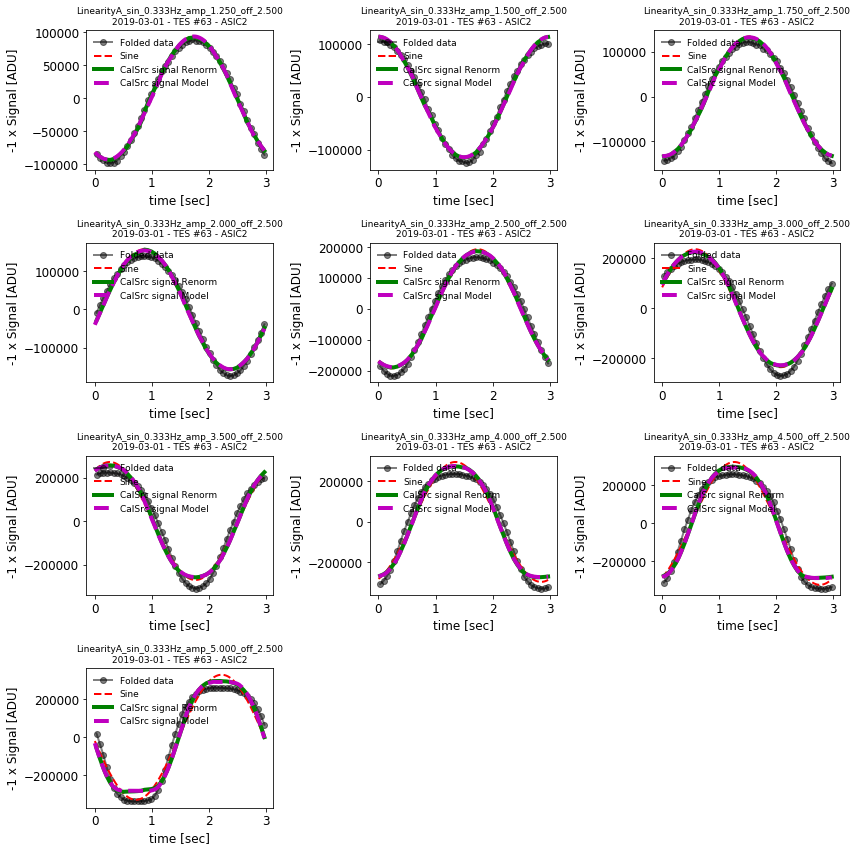

In [73]:
theASIC = 2
theTES = 63

asicindex = theASIC-1
tesindex = theTES-1
rc('figure',figsize=(12,12))
ttt = np.linspace(0,np.max(t),1000)
for ii in xrange(len(tt)):
    subplot(4,3,ii+1)
    p=plot(t,allfolded[ii,asicindex, tesindex, :],'ko-', lw=2, alpha=0.5,label='Folded data')
    plot(ttt, ll.sine(ttt, allresfit[ii,asicindex, tesindex,:]),'r--', lw=2, 
           label='Sine')
    p=plot(tsrc, ll.shift_src([tsrc,allfolded_src[ii,asicindex, tesindex,:], 1./modulation_frequency] , 
                              allresfit_src[ii,asicindex, tesindex,:]),'g-', lw=4, label='CalSrc signal Renorm')
    p=plot(ttt, ll.sinesat(ttt, allresfit_src_model[ii,asicindex, tesindex,:]),'m--', lw=4, label='CalSrc signal Model')
    title(labels[ii]+'\n'+day+' - TES #{} - ASIC{}'.format(theTES, theASIC),fontsize=9)
    xlabel('time [sec]')
    ylabel('-1 x Signal [ADU]')
    legend(fontsize=9,frameon=False, loc='upper left')
tight_layout()

In fact what we want is to see the output of the TES as a function of the input power. So this is what we do in the next cell. The input power can be chosen form the input sinewave (that does not contain the intrinsic non-linearity of the source) or the calsrc data. Of course the latter is the relevant one.

Below we plot the (amplitude, phase and offset adjusted - as above) input signal as a function of the TES measured signal. There are three cases (three lines in the plot below, left columns): 
- fitted sinewave
- calibration source signal
- calibration source model

Each time we fit this data with a linear model and a logistic function model. 

In the case of the linear model one expects the slope to be constant if there is no saturation and to decrease when there is saturation. Therefore to be constant up to a certain modulation amplitude and start to decrease beyond the "non linear" limit. This is shown in the middle column. 

In the case of the logistic finction fit, we plot the width of the logistic curve (parameter pars[2]). Here again it is expected to be small in the case of no saturation and increase when entering in the saturation mode.

In [121]:
methods = ['Fitted Sinewave', 'CalSrc Signal', 'Model CalSrc Signal']
nbm = len(methods)

#### Linear fitting parameters
allres = np.zeros((nbm, 2,len(dirs), 2, 128))
allerr = np.zeros((nbm, 2,len(dirs), 2, 128))

#### Logistic fitting parameters
allres_logistic = np.zeros((nbm, 4,len(dirs), 2, 128))
allerr_logistic = np.zeros((nbm, 4,len(dirs), 2, 128))

for ii in xrange(len(dirs)):
    print('Directory {}/{} : {}'.format(ii+1, len(dirs), dirs[ii]))
    for asicindex in xrange(2):
        print('   Asic {}'.format(asicindex+1))
        for im in xrange(len(methods)):
            print('         Method = {}'.format(methods[im]))
            for tesindex in xrange(128):
                if methods[im]=='Fitted Sinewave':
                    params = allresfit[ii,asicindex, tesindex, :]
                    input_curve = ll.sine(t, params)
                elif methods[im]=='CalSrc Signal':
                    input_curve = ll.shift_src([tsrc,allfolded_src[ii,asicindex, tesindex,:], 
                                                1./modulation_frequency], 
                                               allresfit_src[ii,asicindex, tesindex,:])/np.abs(allresfit_src[ii,asicindex, tesindex,0])
                elif methods[im] == 'Model CalSrc Signal':
                    input_curve = ll.sinesat(tsrc, 
                                             allresfit_src_model[ii,asicindex, tesindex,:])/np.abs(allresfit_src_model[ii,asicindex, tesindex,0])+0.5

                ### Fitting with a straight line
                res = ft.do_minuit(input_curve, allfolded[ii,asicindex, tesindex,:],np.zeros(len(t))+1., 
                       np.array([0.,10000.]), functname=ft.thepolynomial,verbose=False, force_chi2_ndf=True)
                allres[im, :,ii,asicindex, tesindex] = res[1]
                allerr[im, :,ii,asicindex, tesindex] = res[2]

                ### Fitting with an efficiency curve
                if ii ==0:
                    guess = np.array([2*np.max(allfolded[ii,asicindex, tesindex,:]),
                                      np.mean(input_curve),np.std(input_curve),
                                      np.min(allfolded[ii,asicindex, tesindex,:])])
                    #print(guess)
                else:
                    guess = allres_logistic[im, :, ii-1, asicindex, tesindex]
                res_logistic = ft.do_minuit(input_curve, allfolded[ii,asicindex, tesindex,:],np.zeros(len(t))+1., 
                       guess, functname=ll.logistic,verbose=False, force_chi2_ndf=True, nohesse=True)
                allres_logistic[im, :,ii,asicindex, tesindex] = res_logistic[1]
                allerr_logistic[im, :,ii,asicindex, tesindex] = res_logistic[2]
#                 print guess
#                 print res_logistic[1]
#                 print ''


Directory 1/10 : /qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.35.25__LinearityA_sin_0.333Hz_amp_1.250_off_2.500
   Asic 1
         Method = Fitted Sinewave
         Method = CalSrc Signal
         Method = Model CalSrc Signal
   Asic 2
         Method = Fitted Sinewave
         Method = CalSrc Signal
         Method = Model CalSrc Signal
Directory 2/10 : /qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.38.21__LinearityA_sin_0.333Hz_amp_1.500_off_2.500
   Asic 1
         Method = Fitted Sinewave
         Method = CalSrc Signal
         Method = Model CalSrc Signal
   Asic 2
         Method = Fitted Sinewave
         Method = CalSrc Signal
         Method = Model CalSrc Signal
Directory 3/10 : /qubic/Data/Calib-TD/2019-03-01/2019-03-01_14.41.24__LinearityA_sin_0.333Hz_amp_1.750_off_2.500
   Asic 1
         Method = Fitted Sinewave
         Method = CalSrc Signal
         Method = Model CalSrc Signal
   Asic 2
         Method = Fitted Sinewave
         Method = CalSrc Signal
         Method


Fitted Sinewave
138612.01081474955 0.00806561155392659
134383.12735025378 16998.476256252437
146659.59574416428 292.22266992444094
114611.56446874005 313.4311863784659
31803.247194058335 357.71435161957766
28558.997986205566 1572.9657998551372
28394.1500860113 1020.1546747378155
27074.612759064963 1002.2345261169662
25196.28722483419 567.3749334745875
23067.813895258318 578.0314701664508

CalSrc Signal
270.97206580198076 524.9178265984766
210.02051022714036 42.36523881617304
238.58961026916572 0.36239065887549193
182.20312493395556 0.36730522197456333
222.8586127400998 8.497409917365893
302.4501863336103 0.6182459489827382
456.18002889627184 1.0774257331782715
515.1924654794152 1.39767173746945
407.76779152042695 1.2910331897173295
525.6384585897391 1.32151282727841

Model CalSrc Signal
1.0310017456926408 1.748731886061285
1.0109623164988244 0.12074045556808213
1.1087537868699933 0.0019152492946238205
0.8948954427217135 0.05166243376016386
1.0840805348274585 0.0018715841483715205
1.47

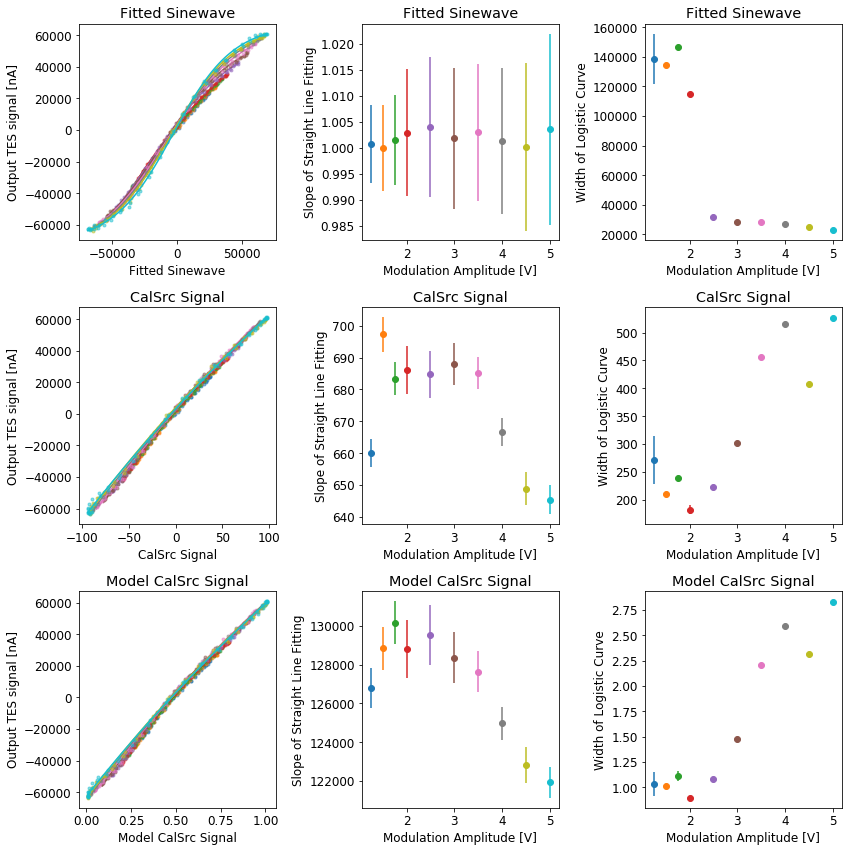

In [122]:
theASIC = 1
theTES = 96

asicindex = theASIC-1
tesindex = theTES-1
for im in xrange(len(methods)):
    print ''
    print methods[im]
    for ii in xrange(len(dirs)):
        subplot(3,3,3*im+1)
        if methods[im]=='Fitted Sinewave':
            params = allresfit[ii,asicindex, tesindex,:]
            input_curve = ll.sine(t, params)
        elif methods[im]=='CalSrc Signal':
            input_curve = ll.shift_src([tsrc,allfolded_src[ii,asicindex, tesindex,:], 
                                        1./modulation_frequency], 
                                       allresfit_src[ii,asicindex, tesindex,:])/np.abs(allresfit_src[ii,asicindex, tesindex,0])
        elif methods[im]=='Model CalSrc Signal':
            input_curve = ll.sinesat(tsrc, 
                                     allresfit_src_model[ii,asicindex, tesindex,:])/np.abs(allresfit_src_model[ii,asicindex, tesindex,0])+0.5

        p=plot(input_curve, allfolded[ii,asicindex, tesindex,:], '.', alpha=0.5)
        xxx = np.linspace(np.min(input_curve),np.max(input_curve),100)
        #plot(xxx, ft.thepolynomial(xxx, allres[:,ii]), color=p[0].get_color())
        plot(xxx, ll.logistic(xxx, allres_logistic[im, :,ii,asicindex, tesindex]), color=p[0].get_color())
        xlabel(methods[im])
        ylabel('Output TES signal [nA]')
        title(methods[im])

    
        subplot(3,3,3*im+2)
        errorbar(amps[ii], allres[im, 0,ii,asicindex, tesindex], yerr=allerr[im, 0,ii,asicindex, tesindex],fmt='o', color=p[0].get_color())
        xlabel('Modulation Amplitude [V]')
        ylabel('Slope of Straight Line Fitting')
        title(methods[im])

        subplot(3,3,3*im+3)
        amp_width = allres_logistic[im, 2,ii,asicindex, tesindex]
        print amp_width, err_amp_width
        err_amp_width = allerr_logistic[im, 2,ii,asicindex, tesindex]
        errorbar(amps[ii], amp_width, yerr=err_amp_width,fmt='o', color=p[0].get_color())
        xlabel('Modulation Amplitude [V]')
        ylabel('Width of Logistic Curve')
        title(methods[im])
tight_layout()

One can try to use the calibration factor observed here w.r.t. the CalSrc signal or its model to have an estimate of the intercalibration between TES.

This assumes that the signal is roughly uniform across the focal plane, which is probably not such a good approximation. But we have put Eccosorb on the window of the instrument to induce a maximum diffusion of the signal so that it's essentially not coherent. When doing so, the signal is observed on many bolometers.

Let's first display the amplitude of the fitted signal on the TES for our three models (sine, calsrc signal, calsrc model)

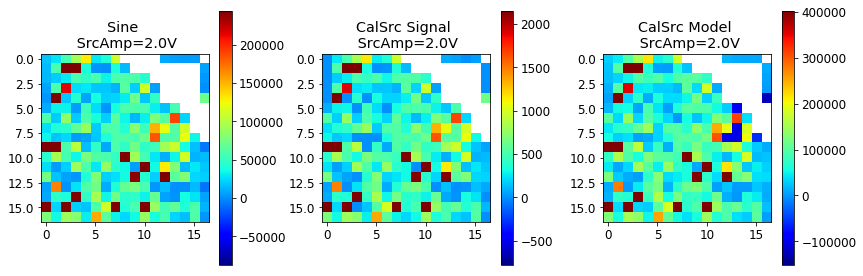

In [161]:
ii=3
rc('figure',figsize=(12,4))
subplot(1,3,1)
img=ft.image_asics(all1=np.ravel(allresfit[ii,:,:,0]))
m = np.mean(img[isfinite(img)])
s = np.std(img[isfinite(img)])
mini = m-nsig*s
maxi = m+nsig*s
imshow(img, vmin=mini, vmax = maxi)
title('Sine \n SrcAmp={}V'.format(amps[ii]))
colorbar()

subplot(1,3,2)
img=ft.image_asics(all1=np.ravel(allresfit_src[ii,:,:,0]))
m = np.mean(img[isfinite(img)])
s = np.std(img[isfinite(img)])
mini = m-nsig*s
maxi = m+nsig*s
imshow(img, vmin=mini, vmax = maxi)
title('CalSrc Signal \n SrcAmp={}V'.format(amps[ii]))
colorbar()

subplot(1,3,3)
img=ft.image_asics(all1=np.ravel(allresfit_src_model[ii,:,:,0]))
m = np.mean(img[isfinite(img)])
s = np.std(img[isfinite(img)])
mini = m-nsig*s
maxi = m+nsig*s
imshow(img, vmin=mini, vmax = maxi)
title('CalSrc Model \n SrcAmp={}V'.format(amps[ii]))
colorbar()

tight_layout()

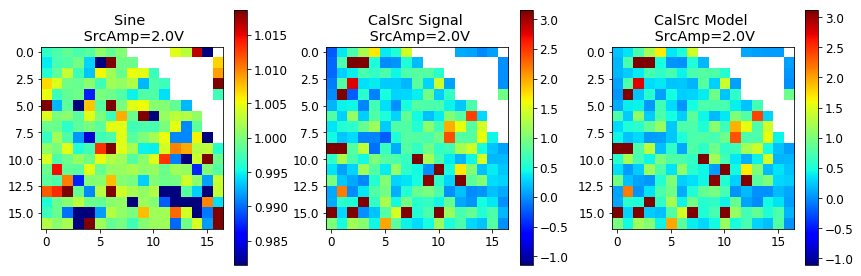

In [162]:
ii=3
nsig = 1
rc('figure',figsize=(12,4))
subplot(1,3,1)
img=ft.image_asics(all1=np.ravel(allres[0, 0,ii,:, :]))
img = img / np.mean(img[isfinite(img)])
m = np.mean(img[isfinite(img)])
s = np.std(img[isfinite(img)])
mini = m-nsig*s
maxi = m+nsig*s
imshow(img, vmin=mini, vmax = maxi)
title('Sine \n SrcAmp={}V'.format(amps[ii]))
colorbar()

subplot(1,3,2)
img=ft.image_asics(all1=np.ravel(allres[1, 0,ii,:, :]))
img = img / np.mean(img[isfinite(img)])
m = np.mean(img[isfinite(img)])
s = np.std(img[isfinite(img)])
mini = m-nsig*s
maxi = m+nsig*s
imshow(img, vmin=mini, vmax = maxi)
title('CalSrc Signal \n SrcAmp={}V'.format(amps[ii]))
colorbar()

subplot(1,3,3)
img=ft.image_asics(all1=np.ravel(allres[2, 0,ii,:, :]))
img = img / np.mean(img[isfinite(img)])
m = np.mean(img[isfinite(img)])
s = np.std(img[isfinite(img)])
mini = m-nsig*s
maxi = m+nsig*s
imshow(img, vmin=mini, vmax = maxi)
title('CalSrc Model \n SrcAmp={}V'.format(amps[ii]))
colorbar()

tight_layout()